In [23]:
import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import pickle

import os
import gdal
import rasterio
import shapely.geometry

#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

In [24]:
#!ls /home/ubuntu/data/TX_post/*.tif

In [36]:
# Tell the script where to look for images
path_to_harvey_images_post = '/home/ubuntu/data/TX_post/'
path_to_harvey_images_pre  = '/home/ubuntu/data/TX_pre/'
output_dir = '/home/ubuntu/data/TX_paired/'

# Load the shapefile with the flooding
file = '/home/ubuntu/data/vector_data/Flood_Analysis_shapefile/20170831_130614_Flood_Analysis.shp'
#file = 'digitalglobe_crowdsourcing_hurricane_harvey_raw_results_20170905.geojson'
flooding = gpd.read_file(file)

# Convert the CRS of the flooding file
flooding.to_crs({'init': 'epsg:4326'}, inplace=True)

In [37]:
flooding.head()

,ID,Latitude,Longitude,Area_KM,Comment,geometry
0,17,30.436438,-95.527609,0.001094,Flood Extraction: derived from RADARSAT-2 new ...,"POLYGON ((-95.5276346461345 30.43616575670645,..."
1,26,30.435607,-95.477129,0.002031,Flood Extraction: derived from RADARSAT-2 new ...,POLYGON ((-95.47712562533235 30.43521799090599...
2,43,30.432520,-95.459499,0.001602,Flood Extraction: derived from RADARSAT-2 new ...,POLYGON ((-95.45948618003833 30.43228203449087...
3,54,30.430833,-95.453894,0.002227,Flood Extraction: derived from RADARSAT-2 new ...,POLYGON ((-95.45378235004287 30.43052907764439...
4,56,30.429961,-95.453775,0.001094,Flood Extraction: derived from RADARSAT-2 new ...,"POLYGON ((-95.45363254287464 30.4297426486536,..."


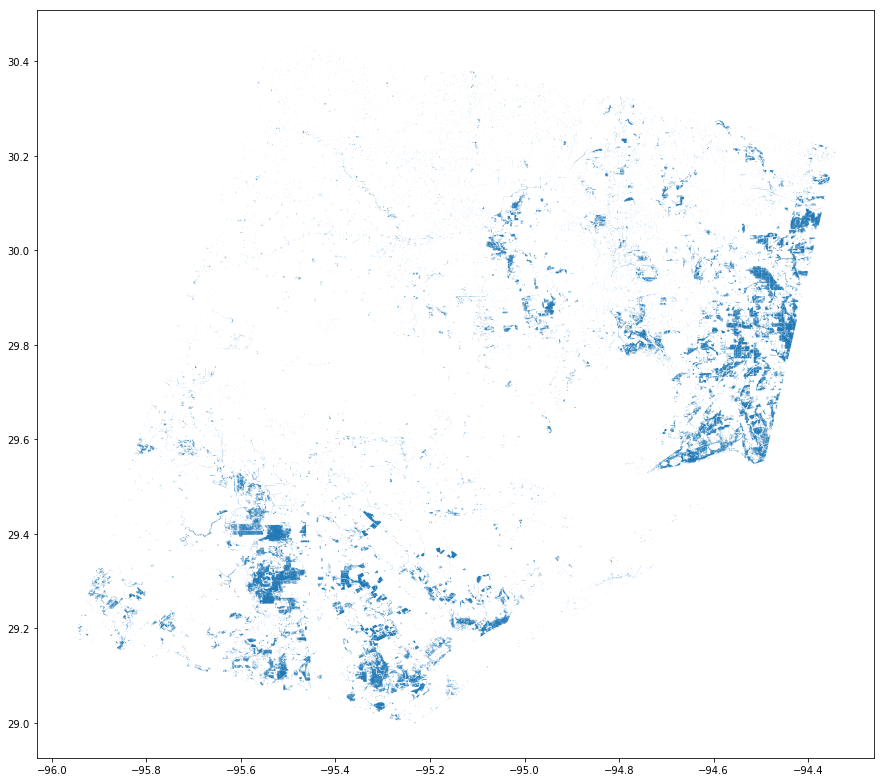

In [27]:
flooding.plot(figsize=(15,15))
plt.show()

In [38]:
# Get a list of all of the tif files, pre and post harvey
tif_files_a = [os.path.join(path_to_harvey_images_post, fn) for fn in os.listdir(path_to_harvey_images_post) if fn.endswith('tif')]
tif_files_b = [os.path.join(path_to_harvey_images_pre,  fn) for fn in os.listdir(path_to_harvey_images_pre)  if fn.endswith('tif')]

In [39]:
tif_files_b

['/home/ubuntu/data/TX_pre/3020333.tif',
 '/home/ubuntu/data/TX_pre/0332211.tif',
 '/home/ubuntu/data/TX_pre/2110020.tif',
 '/home/ubuntu/data/TX_pre/3020133.tif',
 '/home/ubuntu/data/TX_pre/0332203.tif',
 '/home/ubuntu/data/TX_pre/3020201.tif',
 '/home/ubuntu/data/TX_pre/3020210.tif',
 '/home/ubuntu/data/TX_pre/0332021.tif',
 '/home/ubuntu/data/TX_pre/3002123.tif',
 '/home/ubuntu/data/TX_pre/3022010.tif',
 '/home/ubuntu/data/TX_pre/3020330.tif',
 '/home/ubuntu/data/TX_pre/2101133.tif',
 '/home/ubuntu/data/TX_pre/3002120.tif',
 '/home/ubuntu/data/TX_pre/0323330.tif',
 '/home/ubuntu/data/TX_pre/0332331.tif',
 '/home/ubuntu/data/TX_pre/0332210.tif',
 '/home/ubuntu/data/TX_pre/2101331.tif',
 '/home/ubuntu/data/TX_pre/3020223.tif',
 '/home/ubuntu/data/TX_pre/3002233.tif',
 '/home/ubuntu/data/TX_pre/3002033.tif',
 '/home/ubuntu/data/TX_pre/2101102.tif',
 '/home/ubuntu/data/TX_pre/0332020.tif',
 '/home/ubuntu/data/TX_pre/3020103.tif',
 '/home/ubuntu/data/TX_pre/3020323.tif',
 '/home/ubuntu/d

In [58]:
# Get the shape of each image
geometry_b = []
for tif_file in tif_files_b:  
    with rasterio.open(tif_file) as src:
        geometry_b.append(shapely.geometry.box(*src.bounds))

geometry_a = []
for tif_file in tif_files_a:
    with rasterio.open(tif_file) as src:
        geometry_a.append(shapely.geometry.box(*src.bounds))

In [60]:
# Create a GeoDataFrame with the image footprints
footprints_a = gpd.GeoDataFrame({'file_name': tif_files_a}, geometry=geometry_a, crs={'init': 'epsg:4326'})
footprints_b = gpd.GeoDataFrame({'file_name': tif_files_b}, geometry=geometry_b, crs={'init': 'epsg:4326'})

In [61]:
# Filter for just the images that have flooding in them (I know I sqeezed a lot into one line)
footprints_with_flooding_a = footprints_a[footprints_a.index.isin(gpd.sjoin(flooding, footprints_a, how='inner', op='intersects').index_right.unique())]
footprints_with_flooding_b = footprints_b[footprints_b.index.isin(gpd.sjoin(flooding, footprints_b, how='inner', op='intersects').index_right.unique())]

In [62]:
footprints_with_flooding_a.plot()

In [63]:
footprints_with_flooding_b.plot()

Set up a bunch of helper functions

In [64]:
print(len(footprints_with_flooding_a),"files with flooding found in post-flooding images")
print(len(footprints_with_flooding_b),"files with flooding found in pre-flooding images")

(115, 'files with flooding found in post-flooding images')
(81, 'files with flooding found in pre-flooding images')


In [65]:
#find footprint files in both datasets
a_files = footprints_with_flooding_a['file_name']
b_files = footprints_with_flooding_b['file_name']
a_files = [file[-11:] for file in a_files]
b_files = [file[-11:] for file in b_files]
overlap_files = []
for file in a_files:
    if file in b_files:
        overlap_files.append(file)

In [ ]:
#remake the geometry for the overlap footprints (either file set is ok here)
geometry = []
for tif_file in overlap_files:
    with rasterio.open(path_to_harvey_images_post+tif_file) as src:
        geometry.append(shapely.geometry.box(*src.bounds))

# Create a GeoDataFrame with the image footprints
footprints = gpd.GeoDataFrame({'file_name': overlap_files}, geometry=geometry, crs={'init': 'epsg:4326'})

# Filter for just the images that have flooding in them (I know I sqeezed a lot into one line)
footprints_with_flooding = footprints[footprints.index.isin(gpd.sjoin(flooding, footprints, how='inner', op='intersects').index_right.unique())]

In [6]:
#footprints in BOTH SETS and flooding
#footprints_with_flooding.geometry

In [7]:
def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

def get_mask(mask_poly, img_shape, transform):
    # Transform the poly into image coords
    mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, transform)
    
    # Add a buffer to pad it out a little
    mask_poly_pxcoords = mask_poly_pxcoords.buffer(2)
    
    return make_mask(img_shape, mask_poly_pxcoords)

def tile_image(file_name, tile_size):
    src_post = rasterio.open(path_to_harvey_images_post+file_name)
    src_pre  = rasterio.open(path_to_harvey_images_pre +file_name)
    
    width  = src_post.width
    height = src_post.height
    if src_post.height != src_pre.height: print("warning, different image heights")
    
    for i in range(0, width - tile_size, tile_size):
        for j in range(0, height - tile_size, tile_size):
            window = ((j, j + tile_size), (i, i + tile_size))
            
            # Load the tile
            img_post = src_post.read(window=window).transpose([1,2,0])
            
            img_pre  =  src_pre.read(window=window).transpose([1,2,0])
            
            # Get metadata about the tile
            transform = list(np.array(~src_post.window_transform(window))[[0, 1, 3, 4, 2, 5]])
            box = shapely.geometry.box(*src_post.window_bounds(window))
            
            # Skip any image with more than 5% missing pixels
            #print((img == 0).all(axis=2).sum() / (1.0*img.size))
            if (img_post == 0).all(axis=2).sum() / (1.0*img_post.size) > 0.05 or\
                (img_pre == 0).all(axis=2).sum() / (1.0*img_pre.size) > 0.05:
                #print("partial image, skipping")
                continue
                
            yield img_post, img_pre, transform, box

In [8]:
# Start Iterating through tiles

#os.makedirs('/home/ubuntu/data/TX_post/training_tiles')

In [11]:
#set up DataFrame to store filenames and bounding boxes
tile_frame = pd.DataFrame(columns=["tile_no","flooded","post-storm_full","pre-storm_full","post-storm_resized","pre-storm_resized",\
                                   "course_mask_full","course_mask_resized",\
                                   "fine_make_filename","footprint","dry/wet","mask_poly","tile_transform"])
tile_frame.loc[0]=[0,"dumby","flooded","c","d","c","d","e","v","f","g",[1,2,3],3]
tile_frame.set_index("tile_no")

,flooded,post-storm_full,pre-storm_full,post-storm_resized,pre-storm_resized,course_mask_full,course_mask_resized,fine_make_filename,footprint,dry/wet,mask_poly,tile_transform
tile_no,,,,,,,,,,,,
0,dumby,flooded,c,d,c,d,e,v,f,g,"[1, 2, 3]",3


In [12]:
#convert to GeoPandas
geo_df = gpd.GeoDataFrame(tile_frame, geometry=footprints_with_flooding.geometry, crs={'init': 'epsg:4326'})
geo_df.set_index("tile_no")
#geo_df.loc[1] = ["dumby2","c","d","e","f",footprints_with_flooding.geometry[0]]

NameError: name 'footprints_with_flooding' is not defined

In [267]:
print("everything prepped, starting sub-image extraction")
tiles = []
tile_no = 0
control = 0
image_width = 512
resize_width = image_width/2

#for each footprint
for i, row in footprints_with_flooding.iterrows():
    
    #for each tile made by the generator
    print("file ",i,row.file_name,"Tile count starts at",tile_no)
    for tile_img_post, tile_img_pre, tile_transform, tile_box in tile_image(row.file_name, image_width):
        
        # Skip tiles with no flooding (you can try keeping them)
        mask_poly = flooding[flooding.intersects(tile_box)].intersection(tile_box).unary_union
            
        if mask_poly.area < 1e-12:
            print("no flooding on tile ",tile_no)
            continue
        
        mask = get_mask(mask_poly, tile_img_post.shape[:2], tile_transform)
        
        # option to skip tiles with less than 10% flooding (too many false-positives), can also do via GeoDataFrame
        per_flooded = (mask.sum()/255.)/(mask.shape[0]*mask.shape[1])
        #if per_flooded < 0.10:
        #    print("flooding found, but less than 10%, rejecting image")
        #    continue
        
        print("flooding found, tile no:",tile_no,"resizing to",resize_width)
        
        #resize the images if desired
        if image_width != resize_width:
            r = resize_width / (1.0*tile_img_post.shape[1])
            dim = (resize_width, int(tile_img_post.shape[0] * r))
            tile_img_post_resized = cv2.resize(tile_img_post, dim, interpolation = cv2.INTER_AREA)
            tile_img_pre_resized  = cv2.resize(tile_img_pre, dim, interpolation = cv2.INTER_AREA)
        
        #also get mask for resized images
        mask_resized = get_mask(mask_poly, tile_img_post_resized.shape[:2], tile_transform)

        #write save files
        #full_res
        np.save(output_dir+"%d_post_full_img"%tile_no, tile_img_post)
        np.save(output_dir+"%d_pre_full_img"%tile_no, tile_img_pre)
        #resized
        np.save(output_dir+"%d_post_resize_img"%tile_no, tile_img_post_resized)
        np.save(output_dir+"%d_pre_resize_img"%tile_no, tile_img_pre_resized)
        #course_masks
        np.save(output_dir+"%d_mask"%tile_no, mask)
        np.save(output_dir+"%d_resize_mask"%tile_no, mask_resized)
        
        #write an entry to the geopandas Dataframe
        
        #["tile_no","%flooded","post-storm_full","pre-storm_full",\
        #                           "post-storm_resized","pre-storm_resized","course_mask_full","course_mask_resized",\
        #                           "fine_make_filename","footprint","dry/wet","mask_poly","tile_transform"]
        geo_df.loc[tile_no] = [tile_no,per_flooded,"%d_post_resize_img"%tile_no,"%d_pre_resize_img"%tile_no,\
                               "%d_post_full_img"%tile_no,"%d_pre_full_img"%tile_no,\
                               "%d_mask"%tile_no,"%d_resize_mask"%tile_no,None,\
                               row.file_name,"wet",mask_poly,tile_transform,tile_box,]
        
        #write geopandas to file too
        geo_df.to_pickle(output_dir+"GeoDataFrame.pickled")

        tile_no += 1
        #if tile_no > 20: break

everything prepped, starting sub-image extraction
('file ', 0, '3002220.tif', 'Tile count starts at', 0)
('flooding found, tile no:', 0, 'resizing to', 256)
('flooding found, tile no:', 1, 'resizing to', 256)
('flooding found, tile no:', 2, 'resizing to', 256)
('flooding found, tile no:', 3, 'resizing to', 256)
('flooding found, tile no:', 4, 'resizing to', 256)
('flooding found, tile no:', 5, 'resizing to', 256)
('flooding found, tile no:', 6, 'resizing to', 256)
('flooding found, tile no:', 7, 'resizing to', 256)
('flooding found, tile no:', 8, 'resizing to', 256)
('flooding found, tile no:', 9, 'resizing to', 256)
('flooding found, tile no:', 10, 'resizing to', 256)
('no flooding on tile ', 11)
('flooding found, tile no:', 11, 'resizing to', 256)
('flooding found, tile no:', 12, 'resizing to', 256)
('flooding found, tile no:', 13, 'resizing to', 256)
('file ', 1, '3020201.tif', 'Tile count starts at', 14)


KeyboardInterrupt: 

In [ ]:
geo_df.head()

In [242]:
test = pickle.load( open( output_dir+"GeoDataFrame.pickled", "rb" ))
test.head()

,tile_no,%flooded,post-storm_full,pre-storm_full,post-storm_resized,pre-storm_resized,course_mask_full,course_mask_resized,fine_make_filename,footprint,dry/wet,mask_poly,tile_transform,geometry
0,0,0.80323,0_post_resize_img,0_pre_resize_img,0_post_full_img,0_pre_full_img,0_mask,0_resize_mask,None,3002220.tif,wet,(POLYGON ((-95.57181511210993 29.4410615808823...,"[222822.4, 0.0, 0.0, -222822.4, 21295616.0, 65...",POLYGON ((-95.56985294117646 29.44106158088235...
1,1,0.8787,1_post_resize_img,1_pre_resize_img,1_post_full_img,1_pre_full_img,1_mask,1_resize_mask,None,3002220.tif,wet,POLYGON ((-95.56764981800494 29.44136752727207...,"[222822.4, 0.0, 0.0, -222822.4, 21295104.0, 65...",POLYGON ((-95.56755514705883 29.44106158088235...
2,2,0.864578,2_post_resize_img,2_pre_resize_img,2_post_full_img,2_pre_full_img,2_mask,2_resize_mask,None,3002220.tif,wet,(POLYGON ((-95.5654521647227 29.44106158088235...,"[222822.4, 0.0, 0.0, -222822.4, 21294592.0, 65...",POLYGON ((-95.56525735294117 29.44106158088235...
3,3,0.576237,3_post_resize_img,3_pre_resize_img,3_post_full_img,3_pre_full_img,3_mask,3_resize_mask,None,3002220.tif,wet,"(POLYGON ((-95.56505909959365 29.443359375, -9...","[222822.4, 0.0, 0.0, -222822.4, 21294080.0, 65...",POLYGON ((-95.56295955882354 29.44106158088235...
4,4,0.59251,4_post_resize_img,4_pre_resize_img,4_post_full_img,4_pre_full_img,4_mask,4_resize_mask,None,3002220.tif,wet,(POLYGON ((-95.56178077548428 29.4410615808823...,"[222822.4, 0.0, 0.0, -222822.4, 21293568.0, 65...",POLYGON ((-95.56066176470588 29.44106158088235...


In [243]:
#tile_no = 935
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

In [260]:
tile_pick = random.randint(0,tile_no-1)  #chooses a random tile
#geo_df.loc[tile_pick]

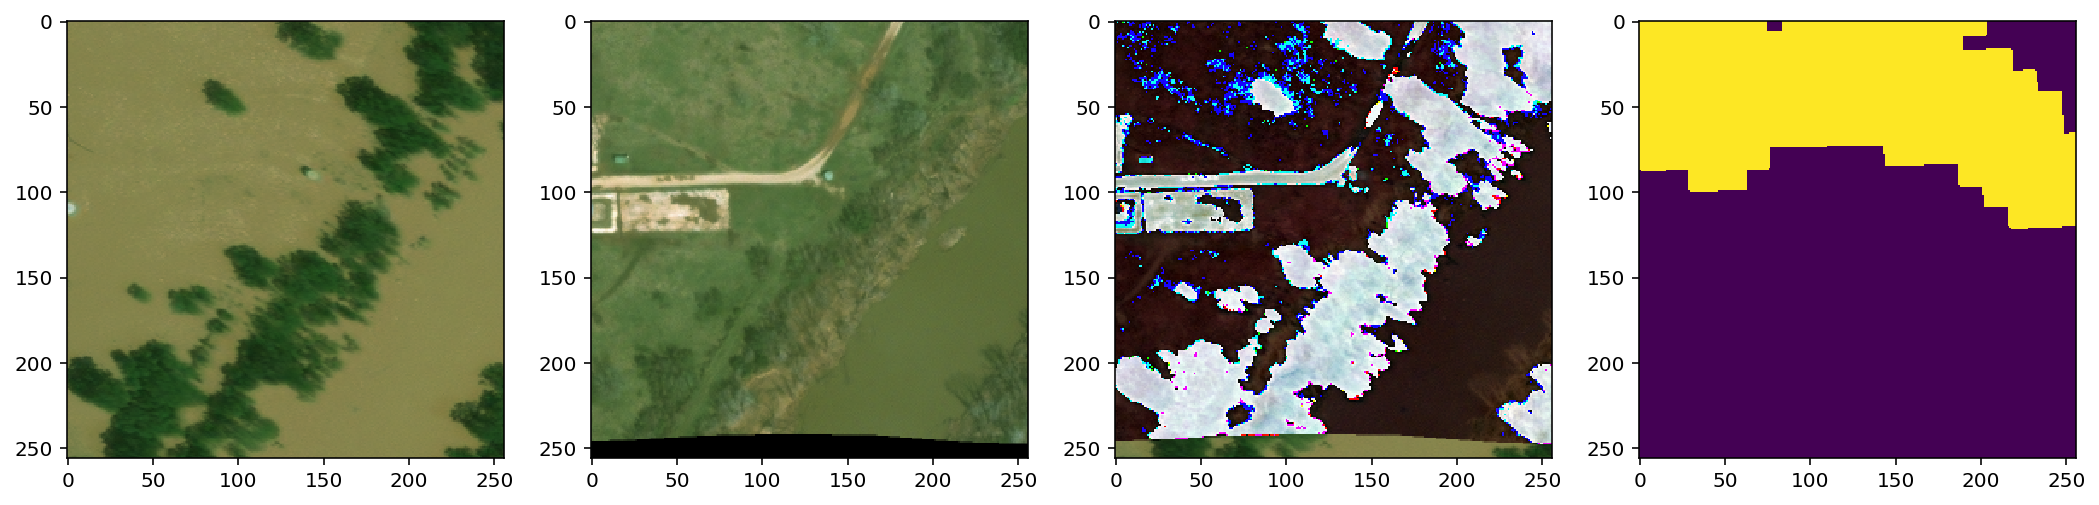

In [261]:
img_post = np.load(output_dir+'%d_post_resize_img.npy'%tile_pick)
img_pre  = np.load(output_dir+'%d_pre_resize_img.npy'%tile_pick)
mask = np.load(output_dir+'%d_resize_mask.npy'%tile_pick)

fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(18,14))
ax1.imshow(img_post)
ax2.imshow(img_pre)
ax3.imshow(img_post-img_pre)
ax4.imshow(mask)
plt.show();

In [250]:
geo_df.loc[tile_pick]

tile_no                                                                1
%flooded                                                          0.8787
post-storm_full                                        1_post_resize_img
pre-storm_full                                          1_pre_resize_img
post-storm_resized                                       1_post_full_img
pre-storm_resized                                         1_pre_full_img
course_mask_full                                                  1_mask
course_mask_resized                                        1_resize_mask
fine_make_filename                                                  None
footprint                                                    3002220.tif
dry/wet                                                              wet
mask_poly              POLYGON ((-95.56764981800494 29.44136752727207...
tile_transform         [222822.4, 0.0, 0.0, -222822.4, 21295104.0, 65...
geometry               POLYGON ((-95.56755514705883

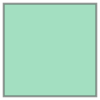

In [246]:
geo_df.loc[tile_pick].geometry